In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sdtw_div.numba_ops import *

# Callable metrics

In [1]:
class SoftDTW():
  def __init__(self, gamma):
    super(SoftDTW, self).__init__()
    self.gamma = gamma

  def __call__(self, x, y):
    return sdtw(x, y, gamma=self.gamma)

In [ ]:
class SoftDTWValueAndGrad():
  def __init__(self, gamma):
    super(SoftDTWValueAndGrad, self).__init__()
    self.gamma = gamma

  def __call__(self, x, y):
    return sdtw_value_and_grad(x, y, gamma=self.gamma)

In [ ]:
class SharpSoftDTW():
  def __init__(self, gamma):
    super(SharpSoftDTW, self).__init__()
    self.gamma = gamma

  def __call__(self, x, y):
    return sharp_sdtw(x, y, gamma=self.gamma)

In [ ]:
class SharpSoftDTWValueAndGrad():
  def __init__(self, gamma):
    super(SharpSoftDTWValueAndGrad, self).__init__()
    self.gamma = gamma

  def __call__(self, x, y):
    return sharp_sdtw_value_and_grad(x, y, gamma=self.gamma)

In [ ]:
class SoftDTWDiv():
  def __init__(self, gamma):
    super(SoftDTWDiv, self).__init__()
    self.gamma = gamma

  def __call__(self, x, y):
    return sdtw_div(x, y, gamma=self.gamma)

In [ ]:
class SoftDTWDivValueAndGrad():
  def __init__(self, gamma):
    super(SoftDTWDivValueAndGrad, self).__init__()
    self.gamma = gamma

  def __call__(self, x, y):
    return sdtw_div_value_and_grad(x, y, gamma=self.gamma)

In [ ]:
class SharpSoftDTWDiv():
  def __init__(self, gamma):
    super(SharpSoftDTWDiv, self).__init__()
    self.gamma = gamma

  def __call__(self, x, y):
    return sharp_sdtw_div(x, y, gamma=self.gamma)

In [ ]:
class SharpSoftDTWDivValueAndGrad():
  def __init__(self, gamma):
    super(SharpSoftDTWDivValueAndGrad, self).__init__()
    self.gamma = gamma

  def __call__(self, x, y):
    return sharp_sdtw_div_value_and_grad(x, y, gamma=self.gamma)

# Setting up the data

In [3]:
import os
import pandas as pd
import seaborn as sns

In [5]:
# Import the times series through Google drive
# The time series are available at this link https://www.cs.ucr.edu/%7Eeamonn/time_series_data_2018/

from google.colab import drive
drive.mount('/content/drive/')

data_location = '/content/drive/MyDrive/'
data_dir = data_location + 'UCRArchive_2018'

ModuleNotFoundError: No module named 'google'

In [4]:
df = pd.read_csv("../DS_ICA_CSV_FR/DS_ICA_data.csv",sep=";", encoding="utf-8")
print(df.columns)
df["TIME_PERIOD"] = pd.to_datetime(df["TIME_PERIOD"], format="%Y-%m")
colonne = df.columns[0]
df_activity = df[(df[colonne] == "L") & (df["SEASONAL_ADJUST"] == "Y")&(df["IDX_TYPE"]=="ICA_SERV")].sort_values(by="TIME_PERIOD", ascending=True)
df_activity_2016 = df_activity[df_activity["TIME_PERIOD"].dt.year == 2012]
print(df_activity_2016)
print(df_activity)

Index(['ACTIVITY', 'SEASONAL_ADJUST', 'IDX_TYPE', 'BASE_PER', 'OBS_STATUS',
       'OBS_STATUS_FR', 'UNIT_MEASURE', 'DECIMALS', 'FREQ', 'MARCHE',
       'CONF_STATUS', 'INDICATOR', 'EMBARGO_DATE', 'TIME_PERIOD', 'OBS_VALUE'],
      dtype='object')
       ACTIVITY SEASONAL_ADJUST  IDX_TYPE  BASE_PER OBS_STATUS OBS_STATUS_FR  \
782335        L               Y  ICA_SERV      2021          R             D   
675520        L               Y  ICA_SERV      2021          R             D   
632402        L               Y  ICA_SERV      2021          A             D   
268838        L               Y  ICA_SERV      2021          A             D   
782334        L               Y  ICA_SERV      2021          A             D   
675519        L               Y  ICA_SERV      2021          R             D   
675513        L               Y  ICA_SERV      2021          R             D   
782286        L               Y  ICA_SERV      2021          R             D   
675511        L               Y 

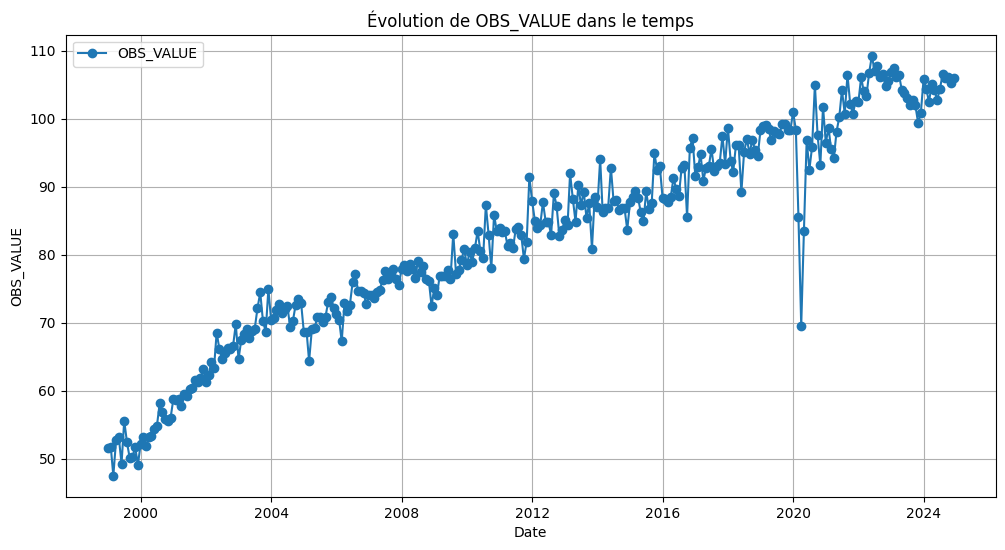

In [16]:
plt.figure(figsize=(12, 6))  # Définir la taille du graphique
plt.plot(df_activity["TIME_PERIOD"], df_activity["OBS_VALUE"],marker='o', label="OBS_VALUE")  
plt.xlabel("Date")
plt.ylabel("OBS_VALUE")
plt.title("Évolution de OBS_VALUE dans le temps")
plt.grid()
plt.legend()
plt.show()

In [5]:
input_size = 20
output_size = 5
def create_time_series_window(values,input_size=20,output_size=5):
        X=[]
        y=[]
        for i in range(len(values) - input_size - output_size):

                X.append(values[i:i + input_size])  
                y.append(values[i + input_size:i + input_size + output_size])  
        return np.array(X), np.array(y)

In [ ]:
# Create training and test sets

catgs = os.listdir(data_dir)
# remove Missing_value_and_variable_length_datasets_adjusted from catgs
catgs.remove('Missing_value_and_variable_length_datasets_adjusted')
catgs_missing = os.listdir(data_dir + '/Missing_value_and_variable_length_datasets_adjusted')
catgs_missing.remove('REAME.md')
catgs_missing.remove('missing_value_and_variable_length_datasets_info.csv')
trainings = []
tests = []

for folder in catgs:
  file = pd.read_csv(data_dir + '/' + folder + '/' + folder + '_TRAIN.tsv', sep='\t', header=None)
  trainings.append(file)
  file = pd.read_csv(data_dir + '/' + folder + '/' + folder + '_TEST.tsv', sep='\t', header=None)
  tests.append(file)

In [ ]:
idxs = []
for i, cat in enumerate(catgs):
  # if trainings[i].shape[1] > 100 and trainings[i].shape[0] > 100 and tests[i].shape[0] > 400: #sufficient data size and samples
  print(i, cat)
  idxs.append(i)

# Data preprocessing

In [6]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
import scipy as sp


/home/onyxia/work/SoftDTWForEcon/.venv/lib/python3.12/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [ ]:
# Missing values detection

idxs = [116, 119, 99, 80, 22, 16]

# Here we look at which time series have missing values

for i in idxs:
  if trainings[i].isna().values.any():
      print(catgs[i] + " has " + str(trainings[i].isna().values.sum()) + " missing values in trainings")
      trainings[i].interpolate(method='linear', inplace=True)
  else:
      print(catgs[i] + " has no missing values in trainings")

  if tests[i].isna().values.any():
      print(catgs[i] + " has " + str(tests[i].isna().values.sum()) + " missing values in tests")
      tests[i].interpolate(method='linear', inplace=True)
  else:
      print(catgs[i] + " has no missing values in tests")
  print("--------------------------------")


In [ ]:
# Checking for outliers

def fig_ax(figsize=(15, 5)):
    return plt.subplots(figsize=figsize)

def outlier_detection(data):
  quantile_threshold_low, quantile_threshold_high = 0.01, 0.997

  fig, ax = fig_ax()
  _ = ax.hist(data, 20)

  threshold_low, threshold_high = np.quantile(
      data, [quantile_threshold_low, quantile_threshold_high]
  )

  _ = ax.axvline(threshold_low, ls="--", color="k")
  _ = ax.axvline(threshold_high, ls="--", color="k")

  fig, ax = fig_ax()
  ax.plot(data, "*-")

  outlier_mask = (data < threshold_low) | (
      data > threshold_high
  )

  ax.plot(
      data[outlier_mask],
      "*",
      label="Outliers",
  )

  plt.legend()

In [ ]:
outlier_detection(trainings[80][1])

# Time series averaging

Experimental setup:
- in the original paper: DTW, SDTW, SHARP, MEANCOST with Euclidean mean initialization and $\gamma = 1$. Divergences with their "biased counterpart" as initialization and $\gamma = 10$.
- here: all discrepancies are computed with $\gamma$ in $\{0.01, 0.1, 1, 10, 100\}$. We keep the same initializations as in the original paper.

In [ ]:
from scipy.optimize import minimize
from tslearn.barycenters import *

In [ ]:
idxs = [116, 119, 99, 80, 22, 16]

In [ ]:
# DTW barycenters
# We use the DBA algorithm to compute the barycenters

dtw_barycenters = []

for i in idxs:
  eucl_mean = np.mean(trainings_array[i][:10], axis=0) # we average on 10 samples from the dataset
  print("DTW barycenters on the " + catgs[i] + " dataset")
  b = dtw_barycenter_averaging(trainings_array[i][:10], init_barycenter=eucl_mean, max_iter=200)
  dtw_barycenters.append(b)
  plt.plot(b, linewidth=2)
  for j in range(10):
    plt.plot(trainings_array[i][j], alpha=0.1, color='black', linewidth=2)
  plt.title("DTW")
  plt.show()

In [ ]:
import pickle

In [ ]:
with open('dtw_barycenters.pickle', 'wb') as fp:
    pickle.dump(dtw_barycenters, fp)

In [ ]:
gammas = [0.01, 0.1, 1., 10., 100.]

In [ ]:
# SoftDTW barycenters

sdtw_barycenters = [[], [], [], [], []]

for i in idxs:
  eucl_mean = np.mean(trainings_array[i][:10], axis=0)
  print("Soft-DTW barycenters on the " + catgs[i] + " dataset")
  for g, gamma in enumerate(gammas):
    color = sns.color_palette("flare")[g]
    func = SoftDTWValueAndGrad(gamma)
    b = barycenter(trainings_array[i][:10], X_init=eucl_mean, value_and_grad=func)
    sdtw_barycenters[g].append(b)
    plt.plot(b, color=color, linewidth=2, label="$\gamma = $" + str(gamma))
    for j in range(10):
      plt.plot(trainings_array[i][j], alpha=0.07, color='black', linewidth=2)
    plt.legend(prop={'size': 30})
    plt.title("Soft-DTW")
    plt.show()
    # save figure
    plt.savefig('/content/drive/MyDrive/plots time series project/' + 'sdtw_' + str(gamma) + '_' + catgs[i] + '.png')

In [ ]:
with open('sdtw_barycenters.pickle', 'wb') as fp:
    pickle.dump(sdtw_barycenters, fp)

In [ ]:
# Sharp barycenters

sharp_barycenters = [[], [], [], [], []]

for i in idxs:
  eucl_mean = np.mean(trainings_array[i][:10], axis=0)
  print("Sharp barycenters on the " + catgs[i] + " dataset")
  for g, gamma in enumerate(gammas):
    color = sns.color_palette("flare")[g]
    func = SharpSoftDTWValueAndGrad(gamma)
    b = barycenter(trainings_array[i][:10], X_init=eucl_mean, value_and_grad=func)
    sharp_barycenters[g].append(b)
    plt.plot(b, color=color, linewidth=2, label="$\gamma = $" + str(gamma))
    for j in range(10):
      plt.plot(trainings_array[i][j], alpha=0.1, color='black', linewidth=2)
    plt.legend(prop={'size': 30})
    plt.title("Sharp")
    plt.show()
    # save figure
    plt.savefig('/content/drive/MyDrive/plots time series project/' + 'sharp_' + str(gamma) + '_' + catgs[i] + '.png')

In [ ]:
with open('sharp_barycenters.pickle', 'wb') as fp:
    pickle.dump(sharp_barycenters, fp)

In [ ]:
# Mean-cost barycenters

mean_cost_barycenters = []

for i in idxs:
  eucl_mean = np.mean(trainings_array[i][:10], axis=0)
  print("Mean-cost barycenters on the " + catgs[i] + " dataset")
  b = barycenter(trainings_array[i][:10], X_init=eucl_mean, value_and_grad=mean_cost_value_and_grad)
  mean_cost_barycenters.append(b)
  plt.plot(b, linewidth=2)
  for j in range(10):
    plt.plot(trainings_array[i][j], alpha=0.1, color='black', linewidth=2)
  plt.title("Mean-cost")
  plt.show()

In [ ]:
with open('mean_cost_barycenters.pickle', 'wb') as fp:
    pickle.dump(mean_cost_barycenters, fp)

In [ ]:
# Soft-DTW divergence

sdtw_div_barycenters = [[], [], [], [], []]

for idx, i in enumerate(idxs):
  print("Soft-DTW divergence barycenters on the " + catgs[i] + " dataset")
  for g, gamma in enumerate(gammas):
    color = sns.color_palette("flare")[g]
    func = SoftDTWDivValueAndGrad(gamma)
    b = barycenter(trainings_array[i][:10], X_init=sdtw_barycenters[g][idx], value_and_grad=func)
    sdtw_div_barycenters[g].append(b)
    plt.plot(b, color=color, linewidth=2, label="$\gamma = $" + str(gamma))
    for j in range(10):
      plt.plot(trainings_array[i][j], alpha=0.1, color='black', linewidth=2)
    plt.legend(prop={'size': 30})
    plt.title("Soft-DTW divergence")
    plt.show()
    # save figure
    plt.savefig('/content/drive/MyDrive/plots time series project/' + 'sdtw_div_' + str(gamma) + '_' + catgs[i] + '.png')

In [ ]:
with open('sdtw_div_barycenters.pickle', 'wb') as fp:
    pickle.dump(sdtw_div_barycenters, fp)

In [ ]:
# Sharp divergence

sharp_div_barycenters = [[], [], [], [], []]

for idx, i in enumerate(idxs):
  print("Sharp divergence barycenters on the " + catgs[i] + " dataset")
  for g, gamma in enumerate(gammas):
    color = sns.color_palette("flare")[g]
    func = SharpSoftDTWDivValueAndGrad(gamma)
    b = barycenter(trainings_array[i][:10], X_init=sharp_barycenters[g][idx], value_and_grad=func)
    sharp_div_barycenters[g].append(b)
    plt.plot(b, color=color, linewidth=2, label="$\gamma = $" + str(gamma))
    for j in range(10):
      plt.plot(trainings_array[i][j], alpha=0.1, color='black', linewidth=2)
    plt.legend(prop={'size': 30})
    plt.title("Sharp divergence")
    plt.show()
    # save figure
    plt.savefig('/content/drive/MyDrive/plots time series project/' + 'sharp_div_' + str(gamma) + '_' + catgs[i] + '.png')

In [ ]:
with open('sharp_div_barycenters.pickle', 'wb') as fp:
    pickle.dump(sharp_div_barycenters, fp)

In [ ]:
# Mean-cost divergence

mean_cost_div_barycenters = []

for idx, i in enumerate(idxs):
  print("Mean-cost divergence barycenters on the " + catgs[i] + " dataset")
  b = barycenter(trainings_array[i][:10], X_init=mean_cost_barycenters[idx], value_and_grad=mean_cost_div_value_and_grad)
  mean_cost_div_barycenters.append(b)
  plt.plot(b, linewidth=2)
  for j in range(10):
    plt.plot(trainings_array[i][j], alpha=0.1, color='black', linewidth=2)
  plt.title("Mean-cost divergence")
  plt.show()

In [ ]:
with open('mean_cost_div_barycenters.pickle', 'wb') as fp:
    pickle.dump(mean_cost_div_barycenters, fp)

### Quantitative results

In [ ]:
from tslearn.metrics import dtw

In [ ]:
for idx, i in enumerate(idxs):
  print("distances for dataset " + catgs[i])
  to_avg = trainings_array[i][:10]
  dtw_dists = np.zeros((len(to_avg), 1))
  sdtw_dists = np.zeros((len(to_avg), len(gammas)))
  sharp_dists = np.zeros((len(to_avg), len(gammas)))
  mean_cost_dists = np.zeros((len(to_avg), 1))
  sdtw_div_dists = np.zeros((len(to_avg), len(gammas)))
  sharp_div_dists = np.zeros((len(to_avg), len(gammas)))
  mean_cost_div_dists = np.zeros((len(to_avg), 1))
  for s_idx, s in enumerate(to_avg):
    dtw_dists[s_idx] = dtw(dtw_barycenters[idx], s)
    mean_cost_dists[s_idx] = dtw(mean_cost_barycenters[idx], s)
    mean_cost_div_dists[s_idx] = dtw(mean_cost_div_barycenters[idx], s)
    for g_idx, g in enumerate(gammas):
      sdtw_dists[s_idx][g_idx] = dtw(sdtw_barycenters[g_idx][idx], s)
      sharp_dists[s_idx][g_idx] = dtw(sharp_barycenters[g_idx][idx], s)
      sdtw_div_dists[s_idx][g_idx] = dtw(sdtw_div_barycenters[g_idx][idx], s)
      sharp_div_dists[s_idx][g_idx] = dtw(sharp_div_barycenters[g_idx][idx], s)
  dtw_dist = np.mean(dtw_dists, axis=0)
  sdtw_dist = np.mean(sdtw_dists, axis=0)
  sharp_dist = np.mean(sharp_dists, axis=0)
  mean_cost_dist = np.mean(mean_cost_dists, axis=0)
  mean_cost_div_dist = np.mean(mean_cost_div_dists, axis=0)
  sdtw_div_dist = np.mean(sdtw_div_dists, axis=0)
  sharp_div_dist = np.mean(sharp_div_dists, axis=0)
  print("dtw: ", (dtw_dist))
  print("sdtw: ", (sdtw_dist))
  print("sharp: ", (sharp_dist))
  print("mean_cost: ", (mean_cost_dist))
  print("mean_cost_div: ", (mean_cost_div_dist))
  print("sdtw_div: ", (sdtw_div_dist))
  print("sharp_div: ", (sharp_div_dist))
  print("-------")

# Time series clustering

We apply the various discrepancies presented in the paper to a task unexamined by the authors: clustering time series with the K-means algorithm.

Experimental setup:
- downsample time series to length 40
- number of clusters equal to the number of classes in the data
- gammas from $1e-4$ to $100$
- max_iter for K-means equal to 30, max_iter for barycenter computation equal to 100
- random initialization

Qualitative comparisons: smoothness of clusters learned

Quantitative comparisons: DTW distance from the cluster center to the time series for each cluster

### Utilities

In [ ]:
from tslearn.clustering import TimeSeriesKMeans

In [ ]:
def make_data(i, samples=100, sz=40):
  X = TimeSeriesResampler(sz=sz).fit_transform(trainings_array[i][:samples])
  return X

In [ ]:
def plot(X, y, n_clusters, km_object, sz=40, title=None, savefig=None):
  for yi in range(n_clusters):
    plt.subplot(n_clusters//2+1, 2, 1+yi)
    for xx in X[y == yi]:
      plt.plot(xx.squeeze(axis=-1), "k-", alpha=.2)
    plt.plot(km_object.centroids[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.title("Cluster %d" % (yi + 1))
  plt.tight_layout()
  if title is not None:
    plt.suptitle(title, y=1.05, size=16)
  plt.show()
  if savefig is not None:
    plt.savefig(savefig)

In [ ]:
# implement the K-means algorithm

class KMeans():

  def __init__(self, metric, n_clusters, init=None, max_iter_outer=100, max_iter_inner=30, tol=1e-5):

    self.n_clusters = n_clusters
    self.max_iter_outer = max_iter_outer
    self.max_iter_inner = max_iter_inner
    self.metric = metric
    self.init = init
    self.tol = tol

  def fit(self, X_train):

    if self.init is None: # Random initialization for the centroids
      self.centroids = [X_train[np.random.choice(range(len(X_train)))] for _ in range(self.n_clusters)]
    else:
      self.centroids = self.init

    # Iterate, adjusting centroids until inertia has converged or until passed max_iter
    iteration = 0
    prev_centroids = None
    diff_inertias = np.inf
    prev_inertia = np.inf
    while diff_inertias > self.tol and iteration < self.max_iter_outer:
      # Sort each datapoint, assigning to nearest centroid
      sorted_points = [[self.centroids[i]] for i in range(self.n_clusters)] # each cluster contains at least its centroid
      for x in X_train:
        if self.metric == "dtw_":
          dists = np.array([dtw(x, centroid) for centroid in self.centroids])
        else:
          dists = np.array([self.metric(x, centroid)[0] for centroid in self.centroids])
        centroid_idx = np.argmin(dists)
        sorted_points[centroid_idx].append(x)
      # Update centroids
      prev_centroids = self.centroids
      if self.metric == "dtw_":
        self.centroids = [dtw_barycenter_averaging(cluster, init_barycenter = np.mean(cluster, axis=0), max_iter=self.max_iter_inner) for cluster in sorted_points]
      else:
        self.centroids = [barycenter(cluster, X_init=np.mean(cluster, axis=0), value_and_grad=self.metric, max_iter=self.max_iter_inner) for cluster in sorted_points]
      for i, centroid in enumerate(self.centroids):
        if np.isnan(centroid).any():  # Catch any np.nans, resulting from an empty centroid
          self.centroids[i] = prev_centroids[i]
      # Compute mean inertia (distance to the nearest centroid)
      inertia = 0
      for i, centroid in enumerate(self.centroids):
        inertia_cluster = 0
        for x in sorted_points[i]:
          if self.metric == "dtw_":
            inertia_cluster += dtw(x, centroid)
          else:
            inertia_cluster += self.metric(x, centroid)[0]
        inertia_cluster /= len(sorted_points[i])
        inertia += inertia_cluster
      inertia /= self.n_clusters
      diff_inertias = np.abs(inertia - prev_inertia)
      prev_inertia = inertia
      iteration += 1

  def evaluate(self, X):

    centroids = []
    centroid_idxs = []
    for x in X:
      if self.metric == "dtw_":
        dists = np.array([dtw(x, centroid) for centroid in self.centroids])
      else:
        dists = np.array([self.metric(x, centroid)[0] for centroid in self.centroids])
      centroid_idx = np.argmin(dists)
      centroids.append(self.centroids[centroid_idx])
      centroid_idxs.append(centroid_idx)
    return centroids, centroid_idxs

### Experiments

In [ ]:
gammas = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]

In [ ]:
idxs = [116, 119, 99, 80, 22, 16]

#### DTW

In [ ]:
km_dtw = []

for i in idxs:
  print("KMeans for: ", catgs[i])
  X = make_data(i)

  metric = "dtw_"
  nb_clusters = len(trainings[i][0].unique()) # number of classes in the dataset
  km = KMeans(metric=metric, n_clusters=nb_clusters, max_iter_outer=30, max_iter_inner=100, init=None, tol=1e-5)
  km.fit(X)
  km_dtw.append(km)
  centroids, centroid_idxs = km.evaluate(X)
  plot(X, np.array(centroid_idxs), n_clusters=nb_clusters, km_object=km, title="DTW", savefig='/content/drive/MyDrive/plots time series project/' + 'KM_DTW_' + catgs[i] + '.png')

print("-------")

In [ ]:
print("DTW:")
km_dtw_dists = np.zeros((1, len(idxs)))

for idx, i in enumerate(idxs):
  print("DTW distances for: " + catgs[i])
  X = make_data(i)
  centroids, centroid_idxs = km_dtw[0].evaluate(X)
  dists = []
  for c, centroid in enumerate(centroids):
    xx = X[np.array(centroid_idxs) == c]
    if len(xx) != 0:
      dists.append(np.mean([dtw(x, centroid) for x in xx])) # mean along the samples axis
  km_dtw_dists[0, idx] = np.mean(dists) # mean among the clusters

In [ ]:
print(np.round(km_dtw_dists, 2))

#### SoftDTW

In [ ]:
km_sdtw = [[] for _ in range(len(gammas))]

for i in idxs:
  print("KMeans for: ", catgs[i])
  X = make_data(i)

  for g, gamma in enumerate(gammas):
    print("gamma: ", gamma)
    metric = SoftDTWValueAndGrad(gamma=gamma)
    nb_clusters = len(trainings[i][0].unique()) # number of classes in the dataset
    km = KMeans(metric=metric, n_clusters=nb_clusters, max_iter_outer=30, max_iter_inner=100, init=None, tol=1e-5)
    km.fit(X)
    km_sdtw[g].append(km)
    centroids, centroid_idxs = km.evaluate(X)
    plot(X, np.array(centroid_idxs), n_clusters=nb_clusters, km_object=km, title="SDTW, gamma: " + str(gamma), savefig='/content/drive/MyDrive/plots time series project/' + 'KM_SDTW_' + str(gamma) + '_' + catgs[i] + '.png')

  print("-------")

In [ ]:
# compute mean DTW distance of time series to centroid for each cluster

print("SoftDTW:")

km_sdtw_dists = np.zeros((len(gammas), len(idxs)))

for idx, i in enumerate(idxs):
  print("DTW distances for: " + catgs[i])
  X = make_data(i)
  for g, gamma in enumerate(gammas):
    centroids, centroid_idxs = km_sdtw[g][0].evaluate(X)
    dists = []
    for c, centroid in enumerate(centroids):
      xx = X[np.array(centroid_idxs) == c]
      if len(xx) != 0:
        dists.append(np.mean([dtw(x, centroid) for x in xx])) # mean along the samples axis
    km_sdtw_dists[g][idx] = np.mean(dists) # mean among the clusters

In [ ]:
for g in range(len(gammas)):
  print("gamma: ", gammas[g])
  print(np.round(km_sdtw_dists[g, :], 2))

#### Sharp

In [ ]:
km_sharp = [[] for _ in range(len(gammas))]

for i in idxs:
  print("KMeans for: ", catgs[i])
  X = make_data(i)

  for g, gamma in enumerate(gammas):
    print("gamma: ", gamma)
    metric = SharpSoftDTWValueAndGrad(gamma=gamma)
    nb_clusters = len(trainings[i][0].unique()) # number of classes in the dataset
    km = KMeans(metric=metric, n_clusters=nb_clusters, max_iter_outer=30, max_iter_inner=100, init=None, tol=1e-5)
    km.fit(X)
    km_sharp[g].append(km)
    centroids, centroid_idxs = km.evaluate(X)
    plot(X, np.array(centroid_idxs), n_clusters=nb_clusters, km_object=km, title="Sharp, gamma: " + str(gamma), savefig='/content/drive/MyDrive/plots time series project/' + 'KM_Sharp_' + str(gamma) + '_' + catgs[i] + '.png')

  print("-------")

In [ ]:
print("Sharp:")
km_sharp_dists = np.zeros((len(gammas), len(idxs)))

for idx, i in enumerate(idxs):
  print("DTW distances for: " + catgs[i])
  X = make_data(i)
  for g, gamma in enumerate(gammas):
    centroids, centroid_idxs = km_sharp[g][0].evaluate(X)
    dists = []
    for c, centroid in enumerate(centroids):
      xx = X[np.array(centroid_idxs) == c]
      if len(xx) != 0:
        dists.append(np.mean([dtw(x, centroid) for x in xx])) # mean along the samples axis
    km_sharp_dists[g][idx] = np.mean(dists) # mean among the clusters

In [ ]:
for g in range(len(gammas)):
  print("gamma: ", gammas[g])
  print(np.round(km_sharp_dists[g, :], 2))

#### Sharp div

In [ ]:
km_sharp_div = [[] for _ in range(len(gammas))]

for i in idxs:
  print("KMeans for: ", catgs[i])
  X = make_data(i)

  for g, gamma in enumerate(gammas):
    print("gamma: ", gamma)
    metric = SharpSoftDTWDivValueAndGrad(gamma=gamma)
    nb_clusters = len(trainings[i][0].unique()) # number of classes in the dataset
    km = KMeans(metric=metric, n_clusters=nb_clusters, max_iter_outer=30, max_iter_inner=100, init=None, tol=1e-5)
    km.fit(X)
    km_sharp_div[g].append(km)
    centroids, centroid_idxs = km.evaluate(X)
    plot(X, np.array(centroid_idxs), n_clusters=nb_clusters, km_object=km, title="Sharp DIV, gamma: " + str(gamma), savefig='/content/drive/MyDrive/plots time series project/' + 'KM_Sharp_Div_' + str(gamma) + '_' + catgs[i] + '.png')

  print("-------")

In [ ]:
print("Sharp Div:")
km_sharp_div_dists = np.zeros((len(gammas), len(idxs)))

for idx, i in enumerate(idxs):
  print("DTW distances for: " + catgs[i])
  X = make_data(i)
  for g, gamma in enumerate(gammas):
    centroids, centroid_idxs = km_sharp_div[g][0].evaluate(X)
    dists = []
    for c, centroid in enumerate(centroids):
      xx = X[np.array(centroid_idxs) == c]
      if len(xx) != 0:
        dists.append(np.mean([dtw(x, centroid) for x in xx])) # mean along the samples axis
    km_sharp_div_dists[g][idx] = np.mean(dists) # mean among the clusters

In [ ]:
for g in range(len(gammas)):
  print("gamma: ", gammas[g])
  print(np.round(km_sharp_div_dists[g, :], 2))

#### Mean Cost

In [ ]:
km_mean_cost = []

for i in idxs:
  print("KMeans for: ", catgs[i])
  X = make_data(i)

  metric = mean_cost_value_and_grad
  nb_clusters = len(trainings[i][0].unique()) # number of classes in the dataset
  km = KMeans(metric=metric, n_clusters=nb_clusters, max_iter_outer=30, max_iter_inner=100, init=None, tol=1e-5)
  km.fit(X)
  km_mean_cost.append(km)
  centroids, centroid_idxs = km.evaluate(X)
  plot(X, np.array(centroid_idxs), n_clusters=nb_clusters, km_object=km, title="Mean cost", savefig='/content/drive/MyDrive/plots time series project/' + 'KM_Meancost_' + catgs[i] + '.png')

  print("-------")

In [ ]:
print("Mean Cost:")
km_meancost_dists = np.zeros((1, len(idxs)))

for idx, i in enumerate(idxs):
  print("DTW distances for: " + catgs[i])
  X = make_data(i)
  centroids, centroid_idxs = km_mean_cost[0].evaluate(X)
  dists = []
  for c, centroid in enumerate(centroids):
    xx = X[np.array(centroid_idxs) == c]
    if len(xx) != 0:
      dists.append(np.mean([dtw(x, centroid) for x in xx])) # mean along the samples axis
  km_meancost_dists[0, idx] = np.mean(dists) # mean among the clusters

In [ ]:
print(np.round(km_meancost_dists, 2))

#### Mean Cost Div

In [ ]:
km_mean_cost_div = []

for i in idxs:
  print("KMeans for: ", catgs[i])
  X = make_data(i)

  metric = mean_cost_div_value_and_grad
  nb_clusters = len(trainings[i][0].unique()) # number of classes in the dataset
  km = KMeans(metric=metric, n_clusters=nb_clusters, max_iter_outer=30, max_iter_inner=100, init=None, tol=1e-5)
  km.fit(X)
  km_mean_cost_div.append(km)
  centroids, centroid_idxs = km.evaluate(X)
  plot(X, np.array(centroid_idxs), n_clusters=nb_clusters, km_object=km, title="Mean cost DIV", savefig='/content/drive/MyDrive/plots time series project/' + 'KM_Meancost_Div_' + catgs[i] + '.png')

  print("-------")

In [ ]:
print("Mean Cost Div:")
km_meancost_div_dists = np.zeros((1, len(idxs)))

for idx, i in enumerate(idxs):
  print("DTW distances for: " + catgs[i])
  X = make_data(i)
  centroids, centroid_idxs = km_mean_cost_div[0].evaluate(X)
  dists = []
  for c, centroid in enumerate(centroids):
    xx = X[np.array(centroid_idxs) == c]
    if len(xx) != 0:
      dists.append(np.mean([dtw(x, centroid) for x in xx])) # mean along the samples axis
  km_meancost_div_dists[0, idx] = np.mean(dists) # mean among the clusters

In [ ]:
print(np.round(km_meancost_div_dists, 2))

#### SoftDTW Div

In [ ]:
km_sdtw_div = [[] for _ in range(len(gammas))]

for i in idxs:
  print("KMeans for: ", catgs[i])
  X = make_data(i)

  for g, gamma in enumerate(gammas):
    print("gamma: ", gamma)
    metric = SoftDTWDivValueAndGrad(gamma=gamma)
    nb_clusters = len(trainings[i][0].unique()) # number of classes in the dataset
    km = KMeans(metric=metric, n_clusters=nb_clusters, max_iter_outer=30, max_iter_inner=100, init=None, tol=1e-5)
    km.fit(X)
    km_sdtw_div[g].append(km)
    centroids, centroid_idxs = km.evaluate(X)
    plot(X, np.array(centroid_idxs), n_clusters=nb_clusters, km_object=km, title="SDTW Div, gamma: " + str(gamma), savefig='/content/drive/MyDrive/plots time series project/' + 'KM_SDTW_Div_' + str(gamma) + '_' + catgs[i] + '.png')

  print("-------")

In [ ]:
print("SoftDTW Div:")
km_sdtw_div_dists = np.zeros((len(gammas), len(idxs)))

for idx, i in enumerate(idxs):
  print("DTW distances for: " + catgs[i])
  X = make_data(i)
  for g, gamma in enumerate(gammas):
    centroids, centroid_idxs = km_sdtw_div[g][0].evaluate(X)
    dists = []
    for c, centroid in enumerate(centroids):
      xx = X[np.array(centroid_idxs) == c]
      if len(xx) != 0:
        dists.append(np.mean([dtw(x, centroid) for x in xx])) # mean along the samples axis
    km_sdtw_div_dists[g][idx] = np.mean(dists) # mean among the clusters

In [ ]:
for g in range(len(gammas)):
  print("gamma: ", gammas[g])
  print(np.round(km_sdtw_div_dists[g, :], 2))

# Time series forecasting

We use the Soft DTW divergence as a loss function for a neural network in order to study its performance in comparison to the Soft DTW and the Mean Squared Error.

Experimental setup:
- For each dataset, we train 3  groups of models:
  - Soft DTW for $\gamma\in \{0.01, 0.1, 1,10,100\}$
  - Soft DTW Div for $\gamma\in \{0.01, 0.1, 1,10,100\}$
  - Mean Squared Error (only one model in this group)
- We use 60% of the dataset to predict the next 40%


Qualitatively, we plot the obtained predictions and compare them to the ground truth.

Quantitavively, we compute the DTW distance and the MSE between the predictions and the ground truth.

## Utilities

In [7]:
# Build MLP for time series prediction.
from tslearn.metrics import SoftDTWLossPyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F

if torch.cuda.is_available():
 dev = "cuda:0"
else:
 dev = "cpu"
device = torch.device(dev)

class MLP(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(MLP, self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.fc2 = nn.Linear(hidden_size, output_size)

  def forward(self, x):

    if not isinstance(x, torch.Tensor):
            x = torch.Tensor(x)

    batch_size = x.size(0)
    x_reshaped = torch.reshape(x, (batch_size, -1))  # Manipulations to deal with time series format
    output = F.sigmoid(self.fc1(x_reshaped))
    output = self.fc2(output)
    return torch.reshape(output, (batch_size, -1, 1))  # Manipulations to deal with time series format

In [ ]:
def train_models(cat, trainings, hidden_size=300, epochs=150, batch_size=50, lr=1e-2, gammas=[1e-2, 1e-1, 1, 10, 100], max_norm=100.,divergence=True):

  i = cat

  X_train = np.array(trainings[i])[:, 1:]
  input_size = int(X_train.shape[1]*0.6)
  output_size = X_train.shape[1] - input_size

  x = torch.Tensor(X_train[:, :input_size]).unsqueeze(-1)
  x = (x - x.mean(dim=0))/x.std(dim=0)
  y = torch.Tensor(X_train[:, input_size:]).unsqueeze(-1)
  y = (y - y.mean(dim=0))/y.std(dim=0)

  X_val = np.array(tests[i])[:, 1:]
  x_val = torch.Tensor(X_val[:, :input_size]).unsqueeze(-1)
  x_val = (x_val - x_val.mean(dim=0))/x_val.std(dim=0)
  x_val=x_val.to(device)
  y_val = torch.Tensor(X_val[:, input_size:]).unsqueeze(-1)
  y_val = (y_val - y_val.mean(dim=0))/y_val.std(dim=0)
  y_val=y_val.to(device)

  models = []
  for gamma in gammas:

    model = MLP(input_size=input_size, hidden_size=hidden_size, output_size=output_size).to(device)
    loss_fn = SoftDTWLossPyTorch(gamma=gamma, normalize=divergence).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # task: predict next values given the first 60% of values

    losses = []

    for epoch in range(epochs):
      shuffled_idxs = torch.randperm(x.size(0))
      for batch_idx in range(0, x.size(0), batch_size):
      # select batch
        idxs = shuffled_idxs[batch_idx:batch_idx + batch_size]
        x_batch = x[idxs].to(device)
        y_batch = y[idxs].to(device)
        pred = model(x_batch)
        optimizer.zero_grad()
        loss = loss_fn(pred, y_batch).mean()
        losses.append(loss.detach().numpy())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
        optimizer.step()
      if epoch % 10 == 0:
        # validation loss
        pred = model(x_val)
        val_loss = loss_fn(pred, y_val).mean()
        print("Epoch: {}, Train loss: {}, Validation loss: {}".format(epoch, loss, val_loss))

    plt.plot(np.array(losses))
    plt.title("gamma = {}".format(gamma))
    plt.show()

    models.append(model)

  # add model with MSE loss

  model = MLP(input_size=input_size, hidden_size=hidden_size, output_size=output_size).to(device)
  loss_fn = nn.MSELoss().to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)

  losses = []

  for epoch in range(epochs):
      shuffled_idxs = torch.randperm(x.size(0))
      for batch_idx in range(0, x.size(0), batch_size):
      # select batch
        idxs = shuffled_idxs[batch_idx:batch_idx + batch_size]
        x_batch = x[idxs].to(device)
        y_batch = y[idxs].to(device)
        pred = model(x_batch)
        optimizer.zero_grad()
        loss = loss_fn(pred, y_batch).mean()
        losses.append(loss.detach().numpy())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
        optimizer.step()
      if epoch % 10 == 0:
        print("Epoch: {}, Loss: {}".format(epoch, loss))

  plt.plot(np.array(losses))
  plt.title("MSE")
  plt.show()

  models.append(model)

  return models

In [8]:
def train_test_split(df,value,split_train,input_size,output_size):
    values = df[value].values
    split_idx = int(len(values)*split_train)
    train_data,test_data=values[:split_idx],values[split_idx:]
    X_train,y_train = create_time_series_window(train_data,input_size,output_size)
    X_test,y_test=create_time_series_window(test_data,input_size,output_size)
    return X_train,y_train,X_test,y_test

In [ ]:
def train_models(value,df, hidden_size=300, epochs=60, batch_size=50, lr=1e-2, gammas=[1e-2, 1e-1, 1, 10, 100], max_norm=100.,divergence=True):


  X_train,y_train,X_test,y_test=train_test_split(df,value,0.6,input_size,output_size)    

  x = torch.Tensor(np.array(X_train)).unsqueeze(-1)
  x = (x - x.mean(dim=0))/x.std(dim=0)
  y = torch.Tensor(np.array(y_train)).unsqueeze(-1)
  y = (y - y.mean(dim=0))/y.std(dim=0)

  X_val =x[-120:].to(device)
  y_val =y[-120:].to(device)
  X_tensor=x[:-120]
  Y_tensor=y[:-120]
  
 


  models = []
  for gamma in gammas:

    model = MLP(input_size=input_size, hidden_size=hidden_size, output_size=output_size).to(device)
    loss_fn = SoftDTWLossPyTorch(gamma=gamma, normalize=divergence).to(device)
    #loss_fn = SoftDTWLoss(gamma=gamma)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # task: predict next values given the first 60% of values

    losses = []

    for epoch in range(epochs):
      print(epoch)
      shuffled_idxs = torch.randperm(X_tensor.size(0))
      for batch_idx in range(0, X_tensor.size(0), batch_size):
      # select batch
        idxs = shuffled_idxs[batch_idx:batch_idx + batch_size]
        x_batch = X_tensor[idxs].to(device)
        y_batch = Y_tensor[idxs].to(device)
        pred = model(x_batch).to(device)
        optimizer.zero_grad()
        loss = loss_fn(pred, y_batch).mean()
        losses.append(loss.detach().cpu().numpy())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
        optimizer.step()
      if epoch % 10 == 0:
        # validation loss
        pred = model(X_val).to(device)
        val_loss = loss_fn(pred, y_val).mean()
        print("Epoch: {}, Train loss: {}, Validation loss: {}".format(epoch, loss, val_loss))
        

    plt.plot(np.array(losses))
    plt.title("gamma = {}".format(gamma))
    plt.show()

    models.append(model)

  # add model with MSE loss

  model = MLP(input_size=input_size, hidden_size=hidden_size, output_size=output_size).to(device)
  loss_fn = nn.MSELoss().to(device)
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)

  losses = []

  for epoch in range(epochs):

      shuffled_idxs = torch.randperm(X_tensor.size(0))
      for batch_idx in range(0, X_tensor.size(0), batch_size):
      # select batch
        print('batch')
        idxs = shuffled_idxs[batch_idx:batch_idx + batch_size]
        x_batch = X_tensor[idxs].to(device)
        y_batch = Y_tensor[idxs].to(device)
        pred = model(x_batch)
        optimizer.zero_grad()
        loss = loss_fn(pred, y_batch).mean()
        losses.append(loss.detach().numpy())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
        optimizer.step()
      if epoch % 10 == 0:
        print("Epoch: {}, Loss: {}".format(epoch, loss))

  plt.plot(np.array(losses))
  plt.title("MSE")
  plt.show()

  models.append(model)

  return models

In [ ]:
def eval_models(models, cat, testings):
  X_test = np.array(testings[cat])[:, 1:]
  input_size = int(X_test.shape[1]*0.6)
  res = []
  for m in range(len(models)):
    result = models[m](torch.Tensor(X_test[:, :input_size]).unsqueeze(-1)).detach().numpy().squeeze()
    # result = result * X_test[:, input_size:].std(1).reshape(-1, 1) + X_test[:, input_size:].mean(1).reshape(-1, 1)
    res.append(result)
  return res

In [ ]:
import seaborn as sns

def plot_forecasts(res, cat, test,gammas):
  input_size = int(np.array(test[cat])[:,1:].shape[1]*0.6)
  output_size = test[cat].shape[1]- input_size

  X_val = np.array(test[cat])[:, 1:]
  X_val = (X_val - X_val.mean(axis=0))/X_val.std(axis=0)
  gt = X_val
  print(gt.shape)
  print(test[cat].shape[0])
  for i in range(0, 10):
    for m in range(len(res)):
      color = sns.color_palette("magma")[m%6]
      if m < len(res)-1:
        plt.plot(np.arange(input_size + output_size - 1), gt[i],color='grey', label='Ground truth')
        plt.plot(np.arange(input_size, input_size + output_size -1), res[m][i], color='red', label='$\gamma$ = {}'.format(gammas[m]), alpha=0.6)
        plt.plot(np.arange(input_size, input_size + output_size -1), res[-1][i],color='green', label='MSE', alpha=0.6)
        plt.axvline(x = input_size, linestyle = 'dashed', color = 'k')
        plt.title("{}".format(gammas[m]))
        plt.legend()
        plt.grid()
        plt.show()
      else:
        plt.plot(np.arange(input_size, input_size + output_size -1), res[m][i],color='green', label='MSE', alpha=0.6)
        plt.axvline(x = input_size, linestyle = 'dashed', color = 'k')
        plt.grid()

        plt.title("{}".format(i))
        plt.legend()
        plt.show()

In [ ]:
from tslearn.metrics import soft_dtw, SoftDTWLossPyTorch, dtw


def error(res, cat, test):
  input_size = int(np.array(test[cat])[:,1:].shape[1]*0.6)
  gt = np.array(test[cat])[:, 1:][np.newaxis, :, input_size:]
  gt = (gt - gt.mean(axis=1))/gt.std(axis=1)
  res = np.array(res)

  # MSE
  mse = np.mean((gt - res)**2, axis=2)
  std_mse = np.std(mse, axis=1)
  mse = np.mean(mse, axis=1)

  # DTW
  dtw_models = np.zeros((len(res), gt.shape[1]))
  for m in range(len(res)):
    for ts in range(gt.shape[1]):
      dist = dtw(gt[0, ts], res[m][ts])
      dtw_models[m][ts] = dist
  std_dtw = np.std(dtw_models, axis=1)
  dtws = np.mean(dtw_models, axis=1)
  print("For " + catgs[cat])
  print("MSE: {} +- {}".format(np.round(mse,2), np.round(std_mse,2)))
  print("DTW: {} +- {}".format(np.round(dtws,2), np.round(std_dtw,2)))

## Experiments

In [11]:
#Indexes of the categories you wish to study
idxs = [116, 119, 22, 16]

#Values of gamma you wish to study
gammas = [1,1000,10000]

### Soft DTW Loss

In [31]:
forecast_models=[]
for i in idxs:
  forecast_models.append(train_models(i, trainings, gammas=gammas,divergence=False))

# This cell takes a while to run depending on the number of datasets that you train on

NameError: name 'trainings' is not defined

In [ ]:
train_models("OBS_VALUE",df, gammas=gammas,divergence=False)

0
Epoch: 0, Train loss: 5.113719463348389, Validation loss: 8.778891563415527
1
2
3
4
5
6
7
8
9
10
Epoch: 10, Train loss: 1.6448343992233276, Validation loss: 8.995756149291992
11
12
13
14
15
16
17
18
19
20
Epoch: 20, Train loss: -1.9968721866607666, Validation loss: 8.8190279006958
21
22
23
24
25
26


In [ ]:
results=[]
for i,idx in enumerate(idxs):
  results.append(eval_models(forecast_models[i],idx,tests))


In [ ]:
for i in range(len(idxs)):
  plot_forecasts(results[i], idxs[i], tests,gammas)
  error(results[i], idxs[i], tests)

### Soft DTW Divergence Loss

In [ ]:
forecast_models=[]
for i in idxs:
  forecast_models.append(train_models(i, trainings, gammas=gammas, divergence=True))

In [ ]:
results=[]
for i,idx in enumerate(idxs):
  results.append(eval_models(forecast_models[i],idx,tests))

In [ ]:
for i in range(len(idxs)):
  plot_forecasts(results[i], idxs[i], tests,gammas)
  error(results[i], idxs[i], tests)